In [36]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.express as px
from helper import *
from features_extractor import CreditFeatureExtractor,feature_descriptions
import math
# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from termcolor import colored
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score, f1_score, roc_curve, auc #To evaluate our model


## 1. Feature Engineering from `credit_report_sample.json`

The objective of this analysis is to extract and engineer all relevant features from the `credit_report_sample.json` dataset.

In [2]:
with open("credit_data/credit_report_sample.json","r") as file:
    json_data = json.load(file) 
    

In [3]:
extractor = CreditFeatureExtractor(feature_descriptions)
features_df = extractor.extract_features(json_data)

In [4]:
features_df.columns

Index(['application_id', 'total_debt', 'credit_score', 'amount_arrear',
       'total_monthly_installment', 'num_accounts', 'num_open_accounts',
       'num_closed_accounts', 'num_performing_accounts',
       'num_non_performing_accounts', 'avg_credit_line', 'employment_status'],
      dtype='object')

In [5]:
features_df

application_id  total_debt  credit_score  amount_arrear  \
0         9711360    105435.0          13.0        24041.0   
1         9714953    294770.0           2.0            0.0   
2         9714978    110919.0         109.0        12000.0   

   total_monthly_installment  num_accounts  num_open_accounts  \
0                    77404.0             7                  3   
1                   132176.0            17                  4   
2                     7000.0             3                  3   

   num_closed_accounts  num_performing_accounts  num_non_performing_accounts  \
0                    1                        7                            0   
1                   10                       17                            0   
2                    0                        2                            1   

   avg_credit_line employment_status  
0    228454.142857   PUBLIC SERVANTS  
1     36564.705882     CIVIL SERVANT  
2    363645.333333           STUDENT

In [6]:
extractor.display_feature_relevance()

                                         Feature Relevance to Risk Scoring                                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                           ┃                                                                                     ┃
┃ Feature Name              ┃ Relevance to Risk Scoring                                                           ┃
┃                           ┃                                                                                     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                           │                                                                                     │
│ total_debt                │ Reflects overall indebtedness. Higher debt strongly correlates with increased       │
│                           │ default risk. A high total debt compared to income indicates...                     │
│                           │                                                                                     │
│                           │                                                                                     │
│ credit_score              │ A fundamental indicator of creditworthiness derived from credit bureau data. Lower  │
│                           │ scores directly indicate a higher risk of default, reflecting a...                  │
│                           │                                                                                     │
│                           │                                                                                     │
│ arrear_amount             │ Directly indicates financial distress. Higher amounts in arrears are a very strong  │
│                           │ predictor of default, signaling an immediate inability to meet...                   │
│                           │                                                                                     │
│                           │                                                                                     │
│ total_monthly_payment     │ Represents the borrower's total monthly debt obligations across all credit          │
│                           │ accounts. A high value relative to income indicates potential financial...          │
│                           │                                                                                     │
│                           │                                                                                     │
│ num_total_accounts        │ The total number of credit accounts held by the borrower, including both open and   │
│                           │ closed accounts. A higher number can sometimes indicate higher...                   │
│                           │                                                                                     │
│                           │                                                                                     │
│ num_open_accounts         │ The number of currently open credit accounts. A large number of open accounts could │
│                           │ suggest the borrower is actively taking on more debt,...                            │
│                           │                                                                                     │
│                           │                                                                                     │
│ num_closed_accounts       │ The number of closed credit accounts. Can provide insights into the borrower's past │
│                           │ credit behavior and financial management. A large number of...                      │
│                           │                                                                                     │
│                           │                           

## 2. Default Prediction Modeling using `credit.csv`

The following steps outline the modeling process for predicting customer defaulting behavior using the `credit.csv` dataset:

*   **Exploratory Data Analysis (EDA):** Conduct a thorough EDA to understand the data's characteristics and identify potential patterns.
*   **Model Training:** Train a predictive model to classify customers based on their likelihood of defaulting.
*   **Scoring Function Justification:** Clearly justify the selection of appropriate scoring function(s) for model evaluation.
*   **Model Evaluation and Interpretation:** Evaluate the model's performance, interpret the results, and provide a detailed discussion of the findings.
*   **Business Impact Assessment:** Estimate the potential business impact of deploying the trained model in decision-making processes.

### 2.1 Exploratory Data Analysis (EDA)


In [7]:
df_csv =  pd.read_csv("credit_data/credit.csv")
df = df_csv.copy() 
#Calculate the number of unique values in each column
print(df.nunique())
#find null/missing values from datset
null_count = df.isnull().sum()
total_values = len(df)
null_percentage = (null_count / total_values) * 100
# print(null_percentage)
df.drop(['Unnamed: 0','telephone'],axis=1,inplace=True)



Unnamed: 0              1000
checking_balance         263
months_loan_duration      33
credit_history             5
purpose                   10
amount                   921
savings_balance          302
employment_length         31
installment_rate           4
personal_status            3
other_debtors              3
residence_history         36
property                   4
age                       53
installment_plan           3
housing                    3
existing_credits           4
default                    2
dependents                 2
telephone                404
foreign_worker             2
job                        4
gender                     2
dtype: int64


#### Feature Engineering 


In [8]:
#Replace all NaN values of checking_balance with zero
df['checking_balance'] = df['checking_balance'].replace(np.nan,0)
df['savings_balance'] = df['savings_balance'].replace(np.nan,0)
df['personal_status'] = df['personal_status'].replace(0, 'single')
df['personal_status'] = df['personal_status'].replace(np.nan, 'single')
df['residence_history'] = df['residence_history'].replace(np.nan, '0 months')
df['residence_history'] = df['residence_history'].apply(to_months)
df['employment_length'] = df['employment_length'].replace(np.nan, '0 months')
df['employment_length']=df['employment_length'].apply(to_months)


In [9]:
df['employment_length_category'] = pd.cut(df['employment_length'], employment_length_category[0], labels=employment_length_category[1], right=True,include_lowest=True)
df['savings_balance_category'] = pd.cut(df['savings_balance'], savings_balance_category[0], labels=savings_balance_category[1], right=True, include_lowest=True)
df['purpose'] = df['purpose'].map(purpose_category_mapping)
df['Target']=df['default'].map({0:"good",1:"bad"})


In [10]:
df.drop(['other_debtors','installment_plan','employment_length','savings_balance'],axis=1,inplace= True)

In [11]:
df.columns

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'installment_rate', 'personal_status', 'residence_history',
       'property', 'age', 'housing', 'existing_credits', 'default',
       'dependents', 'foreign_worker', 'job', 'gender',
       'employment_length_category', 'savings_balance_category', 'Target'],
      dtype='object')

#### Numerical Variables Analysis


In [12]:
numerical = ['checking_balance','months_loan_duration' ,'amount', 'age','residence_history']


C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

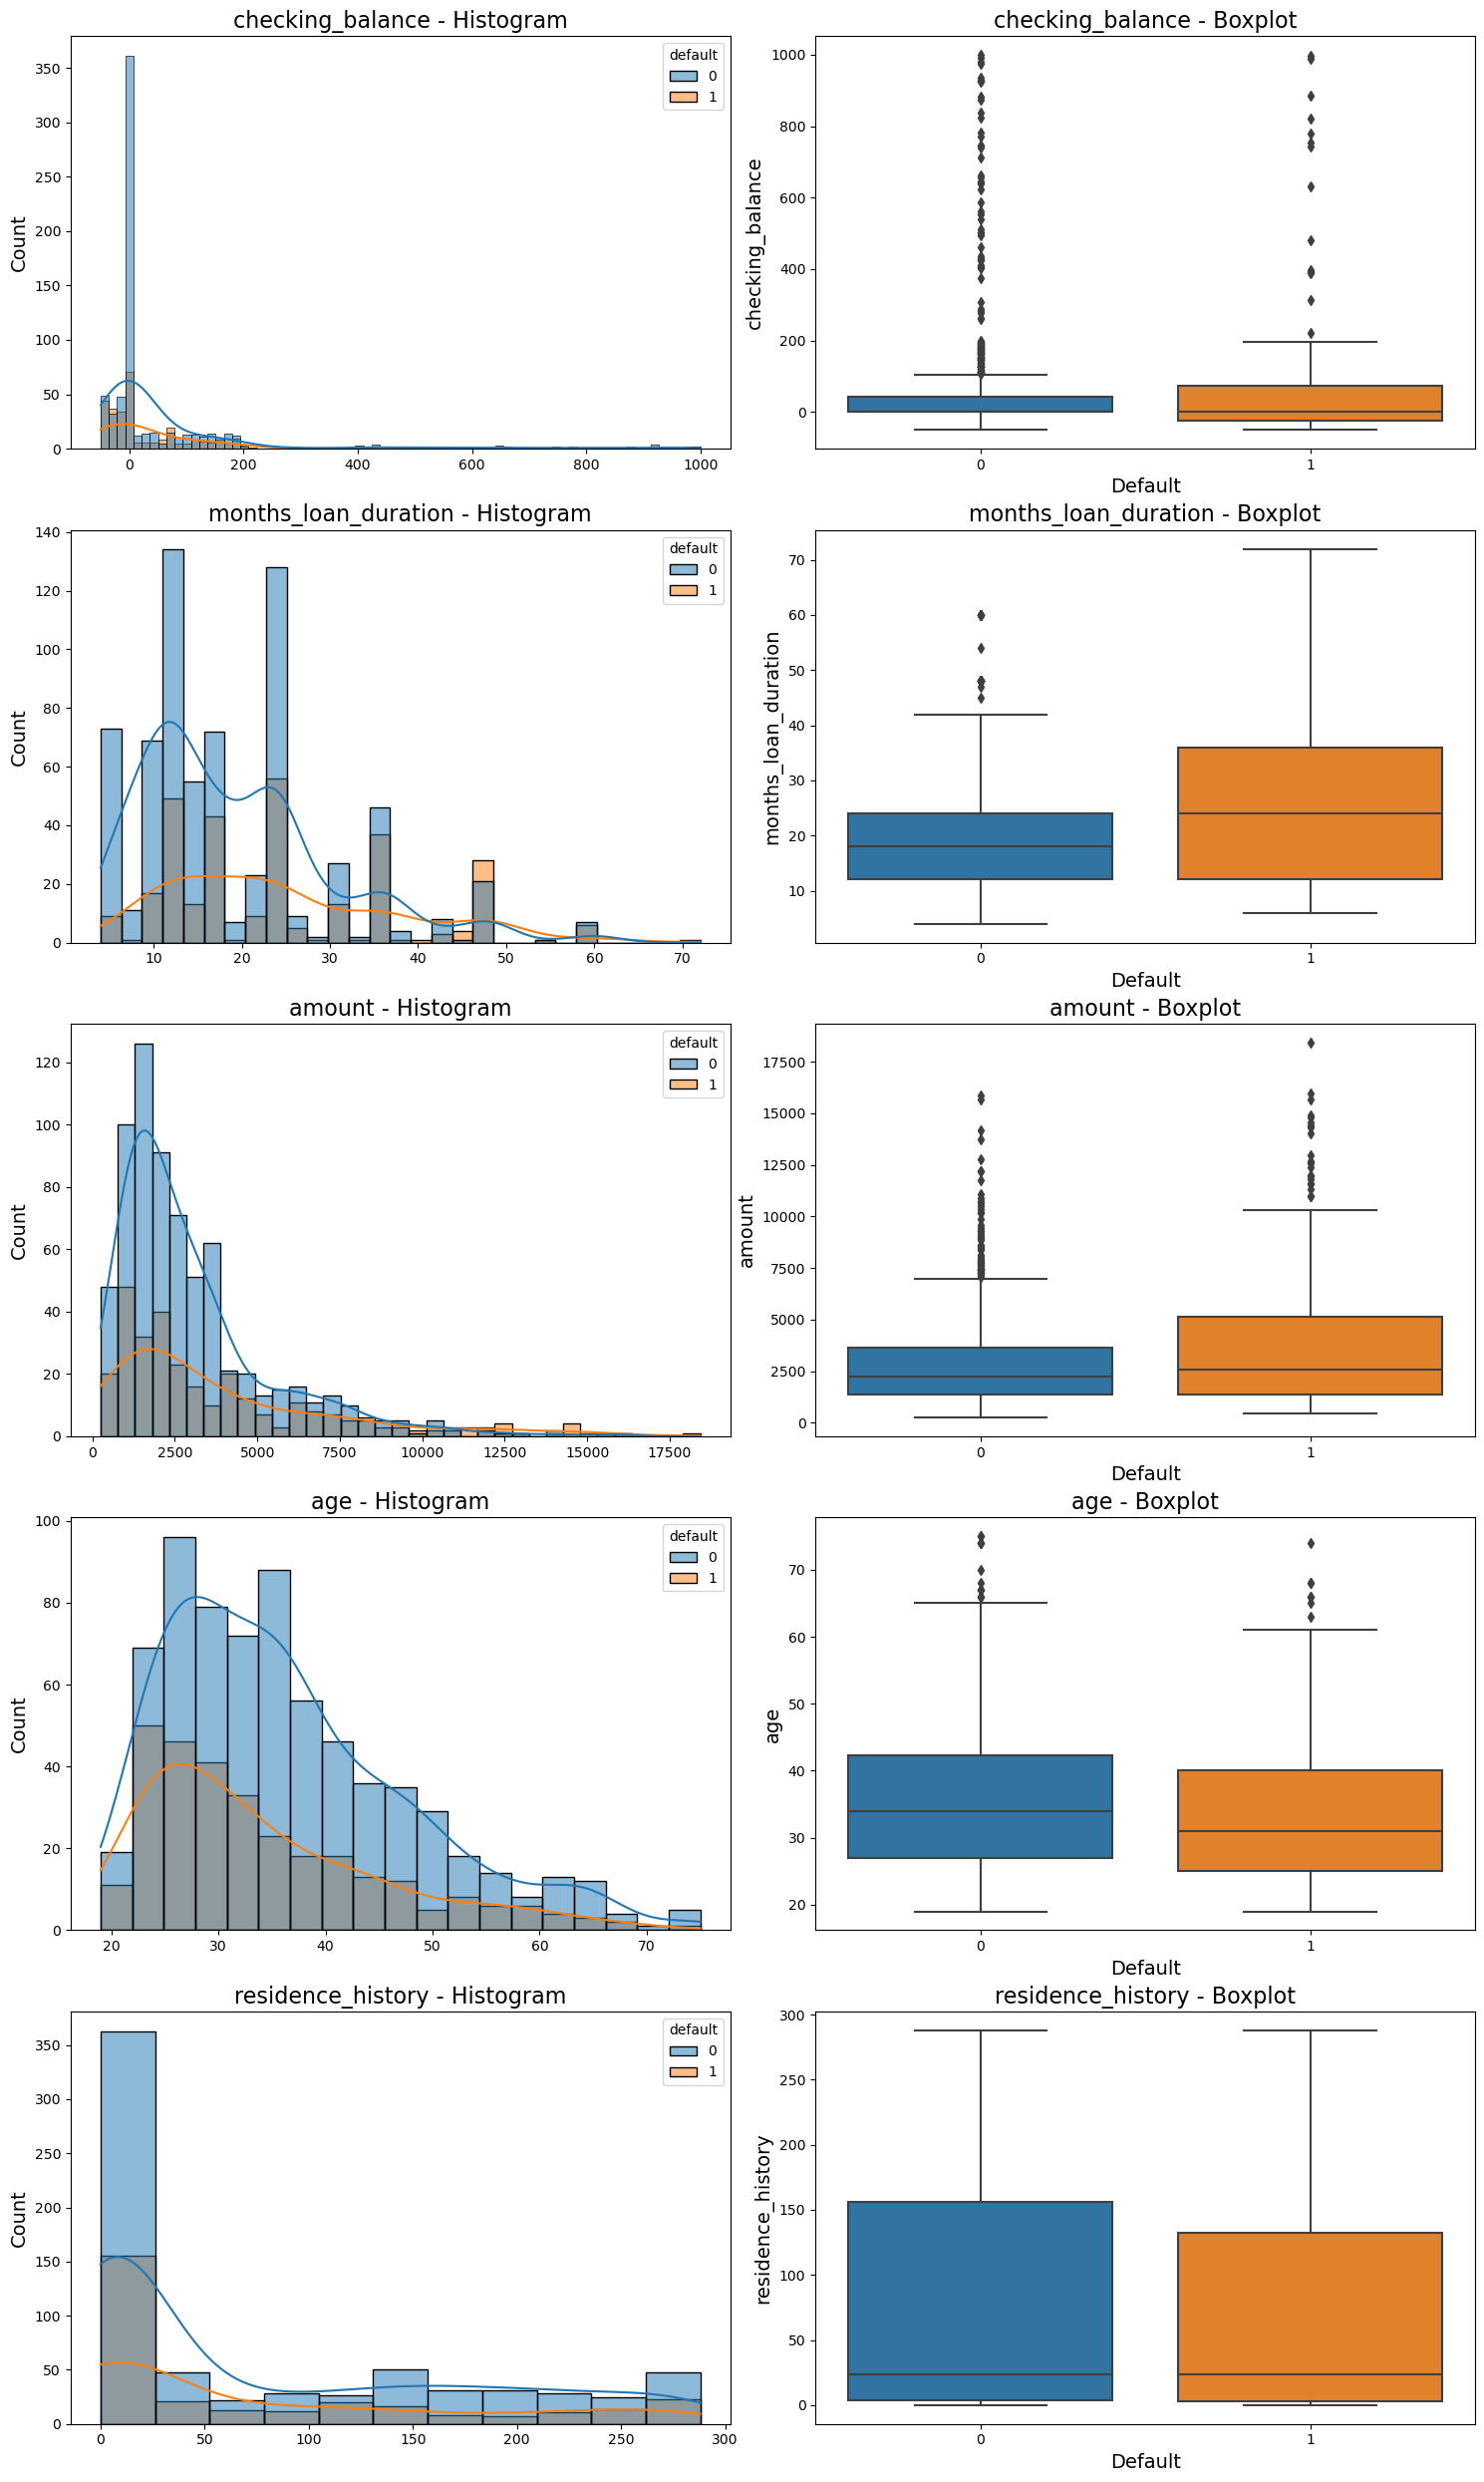

In [13]:
numerical_varaible_analysis(df,numerical)

* #### Months Loan Duration
histogram indicates that the majority of loans are concentrated in the lower duration categories (0-30 months). 
This could imply that customers prefer shorter loan durations, possibly due to lower interest costs or quicker repayment cycles.

* #### Age Distribution;
The age histogram shows a typical distribution, with most customers falling within the 30-50 age range. This demographic could be targeted for specific financial products tailored to their life stage.



#### Categorical Variables Analysis



In [33]:
categorical = [col for col in df.columns if col not in numerical]


In [34]:
categorical=['credit_history','purpose','installment_rate','personal_status','property', 'housing', 'existing_credits','dependents',
 'job','gender','employment_length_category','savings_balance_category']

C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\Kmuds\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
 

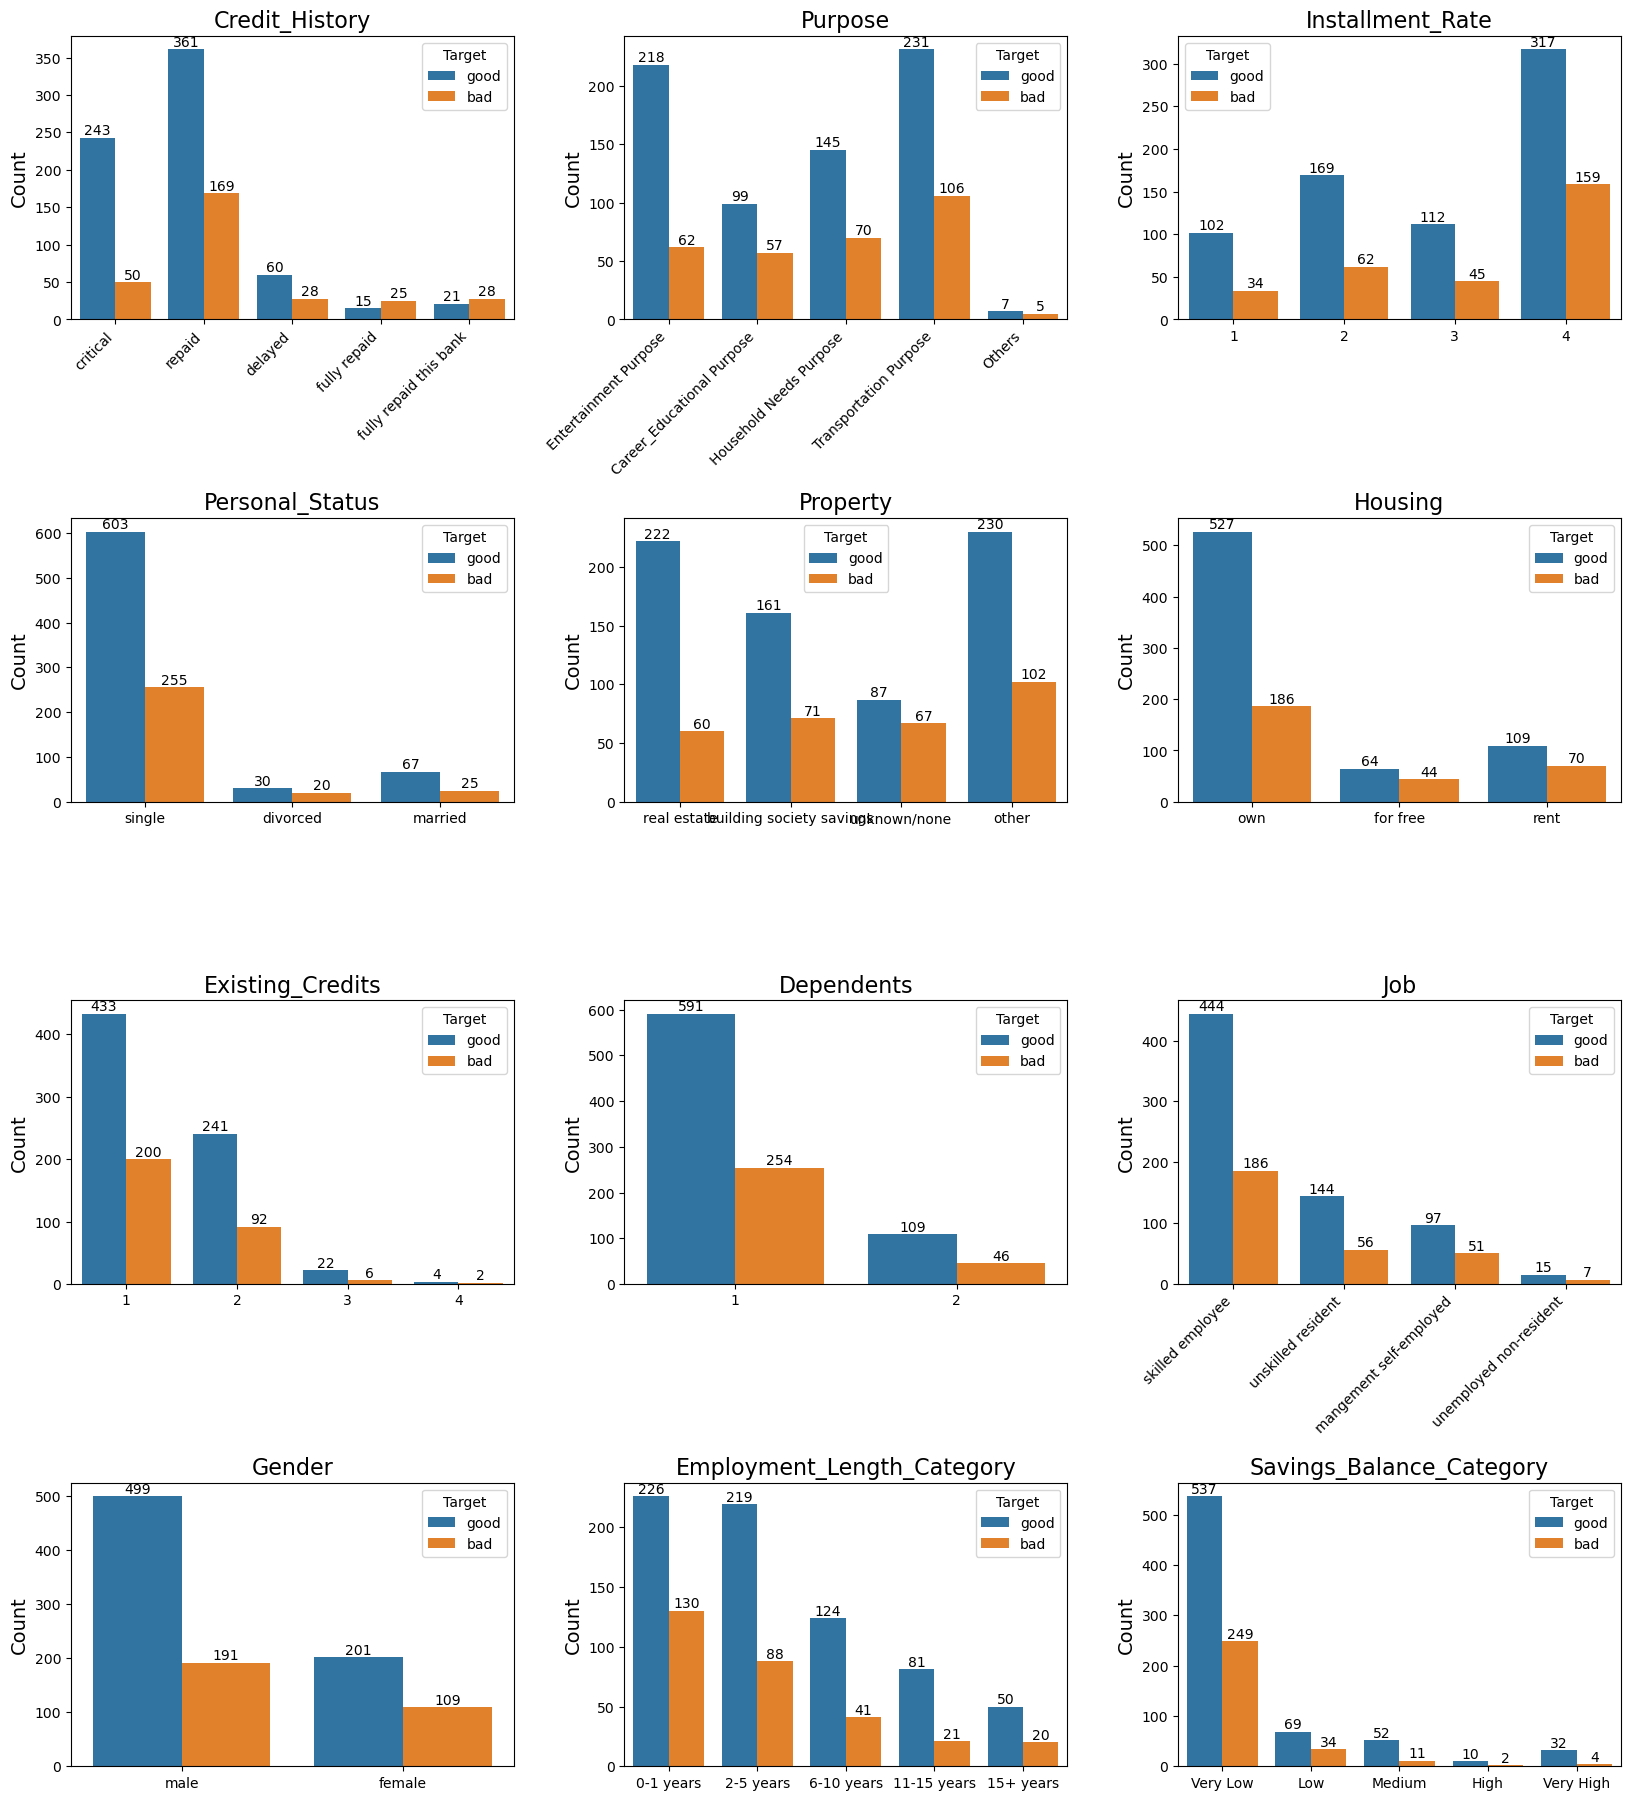

In [19]:
categorical_variables_analysis(df,categorical)

#### Identify Features with the strongest Correlation to Credit Risk


In [26]:
oe = OrdinalEncoder(dtype=np.int64)
df[categorical] = oe.fit_transform(df[categorical])


In [29]:
df.drop('foreign_worker',axis=1,inplace=True)

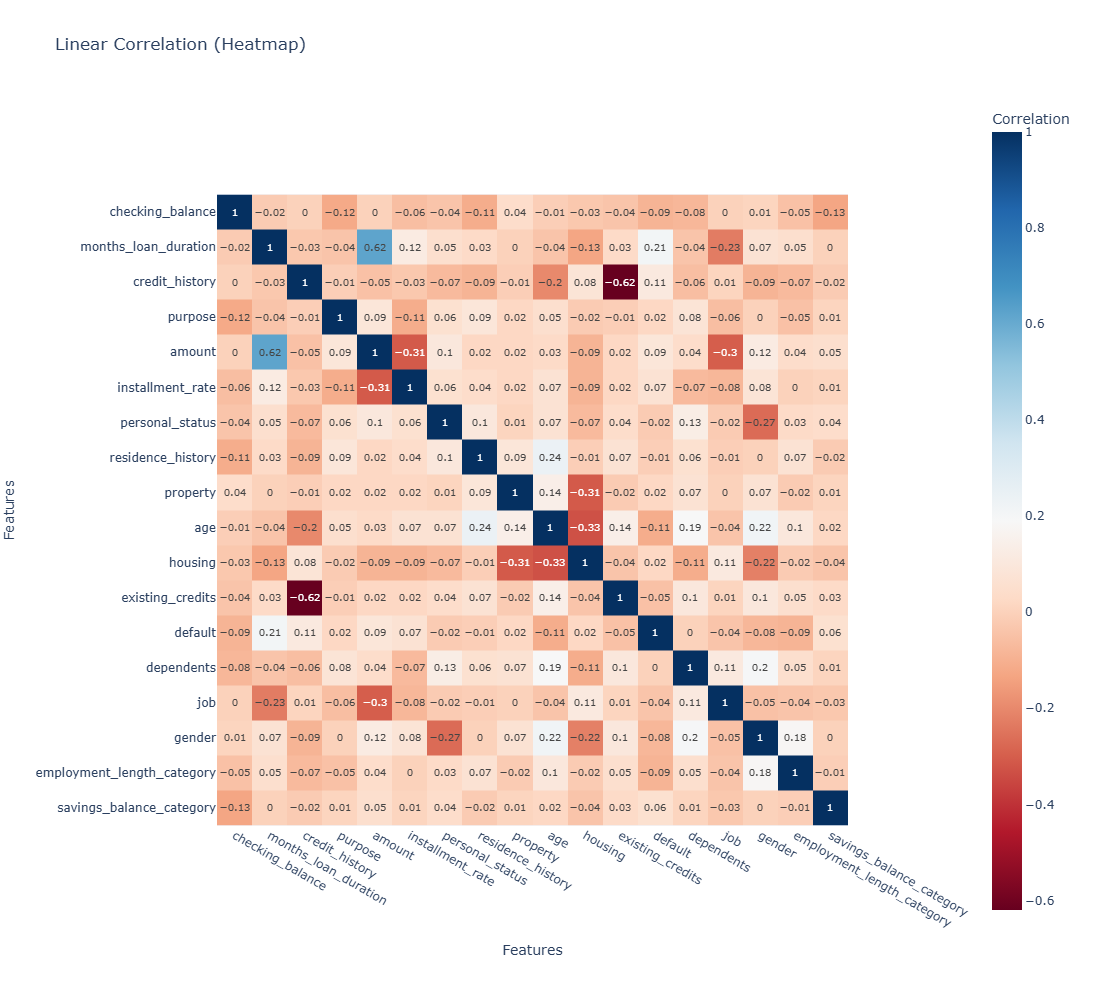

In [30]:
# Generate feature correlation
corr = df.corr(method='spearman').round(2)

# Visualize correlation
corr_heatmap = px.imshow(corr,
                         text_auto=True,
                         labels=dict(x="Features", y="Features",
                                     color="Correlation"),
                         color_continuous_scale=px.colors.sequential.RdBu,
                         title="Linear Correlation (Heatmap)",
                         height=1000
                         )

corr_heatmap.update_layout(
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_title="Features",
    yaxis_title="Features",
    coloraxis_colorbar_title="Correlation"
)

corr_heatmap.show()


### 1. Amount and Months Loan Duration (0.62)
A strong positive correlation exists between loan amount and loan duration. This is expected; larger loans often require longer repayment periods. This multicollinearity might need to be addressed during feature engineering.

### 2. Housing and Savings Balance Category (-0.22)
People who own their own house are more likely to have a higher savings balance.

### 3. Age and Savings Balance Category (0.2)
Older people are more likely to have a higher savings balance.

### 4. Personal Status and Gender (-0.27)
This is likely due to the way these features are encoded (e.g., single/married and male/female). It suggests a relationship between marital status and gender in 

### 5. Strong Negative Correlation
The correlation between credit history and existing credits is -0.62. This is because good credit history will lead to more existing credits.
thsting credits.


### Key Takeaways for Modeling:

* ### Prioritize Credit History (Importance: This is the strongest predictor of default and should be a key feature in any model)
* ### Features: months_loan_duration, amount, installment_rate, and savings_balance_category.
* ### Reason: These features show moderate to weak correlations and might improve model performance.


# 2.2 Model Training


In [38]:
df

checking_balance  months_loan_duration  credit_history  purpose  amount  \
0               -43.0                     6               0        1    1169   
1                75.0                    48               4        1    5951   
2                 0.0                    12               0        0    2096   
3               -32.0                    42               4        2    7882   
4               -23.0                    24               1        4    4870   
..                ...                   ...             ...      ...     ...   
995               0.0                    12               4        2    1736   
996             -30.0                    30               4        4    3857   
997               0.0                    12               4        1     804   
998             -18.0                    45               4        1    1845   
999             194.0                    45               0        4    4576   

     installment_rate  personal_status  residence_history  property  age  \
0                   3                2                 72         2   67   
1                   1                2                  5         2   22   
2                   1                2                 48         2   49   
3                   1                2                156         0   45   
4                   2                2                156         3   53   
..                ...              ...                ...       ...  ...   
995                 2                2                240         2   31   
996                 3                0                 60         0   40   
997                 3                2                192         1   38   
998                 3                2                 96         3   23   
999                 2                2                252         1   27   

     housing  existing_credits  default  dependents  job  gender  \
0          1                 1        0           0    1       1   
1          1                 0        1           0    1       0   
2          1                 0        0           1    3       1   
3          0                 0        0           1    1       1   
4          0                 1        1           1    1       1   
..       ...               ...      ...         ...  ...     ...   
995        1                 0        0           0    3       0   
996        1                 0        0           0    0       1   
997        1                 0        0           0    1       1   
998        0                 0        1           0    1       1   
999        1                 0        0           0    1       1   

     employment_length_category  savings_balance_category  
0                             1                         4  
1                             3                         4  
2                             3                         4  
3                             3                         4  
4                             3                         4  
..                          ...                       ...  
995                           3                         4  
996                           3                         4  
997                           1                         4  
998                           3                         4  
999                           0                         1  

[1000 rows x 18 columns]

In [ ]:
oe = OrdinalEncoder(dtype=np.int64)
# df[categorical] = oe.fit_transform(df[categorical])


In [40]:
df.columns

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'installment_rate', 'personal_status', 'residence_history',
       'property', 'age', 'housing', 'existing_credits', 'default',
       'dependents', 'job', 'gender', 'employment_length_category',
       'savings_balance_category'],
      dtype='object')

In [43]:
df

checking_balance  months_loan_duration  credit_history  purpose  \
0           -0.607395             -1.236478               0        1   
1            0.095753              2.248194               4        1   
2           -0.351163             -0.738668               0        0   
3           -0.541847              1.750384               4        2   
4           -0.488217              0.256953               1        4   
..                ...                   ...             ...      ...   
995         -0.351163             -0.738668               4        2   
996         -0.529929              0.754763               4        4   
997         -0.351163             -0.738668               4        1   
998         -0.458423              1.999289               4        1   
999          0.804860              1.999289               0        4   

       amount  installment_rate  personal_status  residence_history  property  \
0   -0.745131                 3                2          -0.072560         2   
1    0.949817                 1                2          -0.788545         2   
2   -0.416562                 1                2          -0.329033         2   
3    1.634247                 1                2           0.825093         0   
4    0.566664                 2                2           0.825093         3   
..        ...               ...              ...                ...       ...   
995 -0.544162                 2                2           1.722746         2   
996  0.207612                 3                0          -0.200796         0   
997 -0.874503                 3                2           1.209801         1   
998 -0.505528                 3                2           0.183912         3   
999  0.462457                 2                2           1.850982         1   

          age  housing  existing_credits  default  dependents  job  gender  \
0    2.766456        1                 1        0           0    1       1   
1   -1.191404        1                 0        1           0    1       0   
2    1.183312        1                 0        0           1    3       1   
3    0.831502        0                 0        0           1    1       1   
4    1.535122        0                 1        1           1    1       1   
..        ...      ...               ...      ...         ...  ...     ...   
995 -0.399832        1                 0        0           0    3       0   
996  0.391740        1                 0        0           0    0       1   
997  0.215835        1                 0        0           0    1       1   
998 -1.103451        0                 0        1           0    1       1   
999 -0.751642        1                 0        0           0    1       1   

     employment_length_category  savings_balance_category  
0                             1                         4  
1                             3                         4  
2                             3                         4  
3                             3                         4  
4                             3                         4  
..                          ...                       ...  
995                           3                         4  
996                           3                         4  
997                           1                         4  
998                           3                         4  
999                           0                         1  

[1000 rows x 18 columns]

In [42]:
scaler = StandardScaler()
df[numerical] = scaler.fit_transform(df[numerical])

In [44]:
y=df['default']
X = df.drop(columns=['default'])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


In [46]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, random_state=42, max_depth=8)

model.fit(X_train, y_train)


0:	learn: 0.6538799	total: 147ms	remaining: 2m 26s
1:	learn: 0.6190167	total: 151ms	remaining: 1m 15s
2:	learn: 0.5865569	total: 155ms	remaining: 51.5s
3:	learn: 0.5655083	total: 158ms	remaining: 39.4s
4:	learn: 0.5483125	total: 162ms	remaining: 32.1s
5:	learn: 0.5295507	total: 165ms	remaining: 27.3s
6:	learn: 0.5062804	total: 167ms	remaining: 23.7s
7:	learn: 0.4977254	total: 170ms	remaining: 21.1s
8:	learn: 0.4835291	total: 173ms	remaining: 19.1s
9:	learn: 0.4715276	total: 176ms	remaining: 17.4s
10:	learn: 0.4587890	total: 179ms	remaining: 16.1s
11:	learn: 0.4548232	total: 180ms	remaining: 14.8s
12:	learn: 0.4423158	total: 183ms	remaining: 13.9s
13:	learn: 0.4320845	total: 186ms	remaining: 13.1s
14:	learn: 0.4216965	total: 189ms	remaining: 12.4s
15:	learn: 0.4118473	total: 192ms	remaining: 11.8s
16:	learn: 0.4051235	total: 196ms	remaining: 11.3s
17:	learn: 0.3962994	total: 200ms	remaining: 10.9s
18:	learn: 0.3879873	total: 204ms	remaining: 10.5s
19:	learn: 0.3778849	total: 207ms	remai

In [47]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test,y_pred) 
beta_score = fbeta_score(y_test, y_pred, beta=2) 
f1score = f1_score(y_test, y_pred) 
cm = confusion_matrix(y_test, y_pred)


In [49]:
print(f"Acurácy: {accuracy}" )
print(f"Confusion Matrix: {cm}" )
print(f"F-beta score: {beta_score}" )
print(f"F1 Score: {f1score}" )
print("\n")
print(classification_report(y_test, y_pred))

Acurácy: 0.79
Confusion Matrix: [[134   7]
 [ 35  24]]
F-beta score: 0.44943820224719105
F1 Score: 0.5333333333333334


              precision    recall  f1-score   support

           0       0.79      0.95      0.86       141
           1       0.77      0.41      0.53        59

    accuracy                           0.79       200
   macro avg       0.78      0.68      0.70       200
weighted avg       0.79      0.79      0.77       200



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted', ylabel='Actual'>

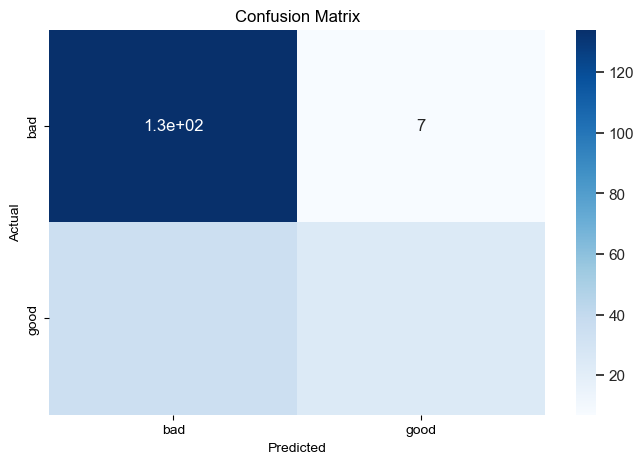

In [50]:
y_true = ["bad", "good"]
y_pred = ["bad", "good"]
df_cm = pd.DataFrame(cm, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
df_cm.dtypes

plt.figure(figsize = (8,5))
plt.title('Confusion Matrix')
sns.set(font_scale=1)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size

In [51]:
def format_percent(value):
    return f'{value:.2%}'

total = sum(sum(cm))
sensitivity_recall = cm[0, 0] / (cm[0, 0] + cm[1, 0])
print(colored('Sensitivity_recall : ', 'blue', attrs=['bold']), colored(format_percent(sensitivity_recall), 'blue', attrs=['bold']))

Specificity = cm[1, 1] / (cm[1, 1] + cm[0, 1])
print(colored('Specificity: ', 'green', attrs=['bold']), colored(format_percent(Specificity), 'green', attrs=['bold']))

precision = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print(colored('Precision: ', 'yellow', attrs=['bold']), colored(format_percent(precision), 'yellow', attrs=['bold']))

accuracy = (cm[0, 0] + cm[1, 1]) / (cm[0, 0] + cm[0, 1] + cm[1, 0] + cm[1, 1])
print(colored('Accuracy: ', 'magenta', attrs=['bold']), colored(format_percent(accuracy), 'magenta', attrs=['bold']))


Sensitivity_recall :  79.29%
Specificity:  77.42%
Precision:  95.04%
Accuracy:  79.00%


Área under curve: 0.76


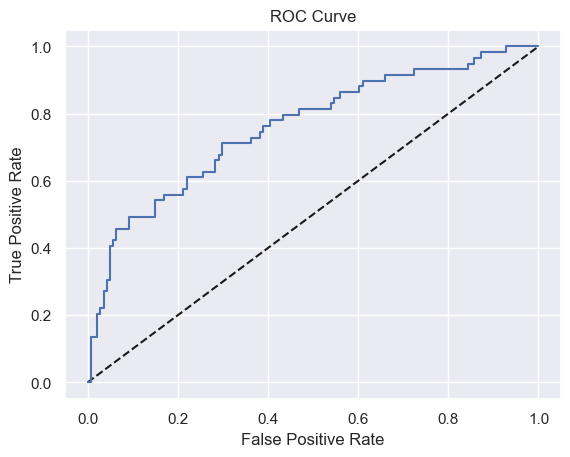

In [53]:
#Predicting proba
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr_cat, tpr_cat, thresholds = roc_curve(y_test, y_pred_prob)

print("Área under curve: %.2f" %auc(fpr_cat, tpr_cat)) 

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_cat, tpr_cat)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<Axes: xlabel='Importances', ylabel='Feature Id'>

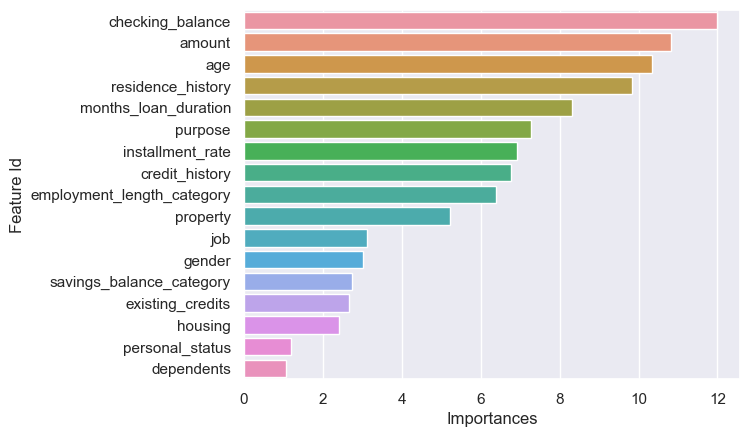

In [54]:
feature_importance = model.get_feature_importance(prettified=True)
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)

## Model Evaluation Metrics:


**Model Evaluation Metrics:**

| Metric             | Value    | Description                                                                                                                                                    |
|----------------------|----------|----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Accuracy             | 79.00%   | Percentage of correctly classified applications. Can be misleading in imbalanced datasets.                                                                     |
| Sensitivity/Recall   | 79.29%   | Percentage of actual defaults correctly identified. Crucial for minimizing losses.                                                                          |
| Specificity          | 77.42%   | Percentage of non-defaults correctly identified.                                                                                                                |
| Precision            | 95.04%   | Of those predicted to default, the percentage that actually defaulted. High precision means fewer false positives.                                           |
| Area Under the Curve (AUC) | 0.76     | Measures the model's ability to distinguish between classes. 0.5 is random guessing, 1.0 is perfect.                                                              |

**Interpretation:**

The model shows a reasonable balance between sensitivity and specificity. While precision is high, recall could be improved. The AUC of 0.76 suggests moderate discriminatory power.

**Feature Importance Analysis:**

The following table summarizes the feature importances derived from the model, providing insights into the relative contribution of each feature to the prediction of loan defaults:

| Feature                     | Importance | Category                    |
|------------------------------|------------|-----------------------------|
| `checking_balance`           | 11.98      | Current Financial Situation |
| `amount`                     | 10.83      | Current Financial Situation |
| `age`                        | 10.35      | Personal Characteristics    |
| `residence_history`          | 9.83       | Personal Characteristics    |
| `months_loan_duration`       | 8.31       | Loan Terms                  |
| `purpose`                    | 7.28       | Loan Details                |
| `installment_rate`           | 6.91       | Loan Terms                  |
| `credit_history`             | 6.76       | Credit History              |
| `employment_length_category` | 6.37       | Employment History          |
| `property`                   | 5.21       | Assets/Collateral           |
| `job`                        | 3.10       | Employment Details          |
| `gender`                     | 3.00       | Personal Characteristics    |
| `savings_balance_category`   | 2.73       | Savings                     |
| `existing_credits`           | 2.67       | Credit History              |
| `housing`                    | 2.40       | Housing                     |
| `personal_status`            | 1.20       | Personal Characteristics    |
| `dependents`                 | 1.06       | Personal Circumstances      |

**Interpretation:**

The features can be broadly categorized as follows, based on their importance:

*   **Key Predictors:** `checking_balance`, `amount`, `age`, `residence_history`, and `months_loan_duration` are the most influential features. This suggests that a customer's current financial situation (checking balance, loan amount), personal characteristics (age, residence history), and loan terms (loan duration) are the strongest predictors of default.
*   **Moderate Predictors:** `purpose`, `installment_rate`, `credit_history`, and `employment_length_category` contribute moderately to the model's predictions. These provide further context regarding the loan's purpose, affordability, credit history, and employment stability.
*   **Less Important Features:** Features like `property`, `job`, `gender`, `savings_balance_category`, `existing_credits`, `housing`, `personal_status`, and `dependents` have relatively lower importance scores. While they might have some minor influence, they are less crucial for predicting default ccal and non-technical audiences.

## ***Business Impact Assessment:** 

**Estimating the Business Impact of Model Deployment:**

To estimate the potential business impact, we need to consider the financial implications of the model's predictions. This involves quantifying the benefits of reducing defaults against the costs of rejecting potentially good loan applications.

**Key Metrics and Costs (Example Values - Replace with your actual data):**

*   **Average Loan Amount:** €10,000 (Euro)
*   **Historical Default Rate (Baseline):** 5% (Without the model)
*   **Cost of a Default (CoD):** €10,000 (Loss of principal, interest, recovery costs)
*   **Cost of Rejecting a Good Applicant (CoR):** €1,000 (Lost potential profit)
*   **Monthly Loan Applications:** 1,000

**Model Performance Metrics:**

*   **Sensitivity (Recall):** 79.29% (True Positive Rate)
*   **Specificity:** 77.42% (True Negative Rate)
*   **Precision:** 95.04%

**Calculations:**

1.  **Expected Defaults Without the Model:** 1,000 applications \* 5% default rate = 50 defaults

2.  **Model Predictions:**
    *   **True Positives (TP):** 50 actual defaults \* 79.29% sensitivity ≈ 40 defaults correctly predicted
    *   **False Negatives (FN):** 50 - 40 = 10 defaults missed by the model
    *   **False Positives (FP):** Using Precision: 95.04% = TP / (TP + FP) => 0.9504 = 40 / (40 + FP) => FP ≈ 2 (rounded)

3.  **Financial Impact:**
    *   **Losses Without Model:** 50 defaults \* €10,000/default = €500,000
    *   **Losses With Model (Due to False Negatives):** 10 FN \* €10,000/default = €100,000
    *   **Cost of False Positives:** 2 FP \* €1,000/rejected applicant = €2,000
    *   **Net Savings (Monthly):** €500,000 - and adapt to changing market conditions.

**Conclusion:**

Based on the example values, deploying the model could potentially save the lending institution approximately €398,000 per month by reducing loan losses. However, the actual impact will depend on the accuracy of the cost estimates, the model's petional efficiency, and customer satisfaction.